In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
true = pd.read_csv("../input/fake-and-real-news-dataset/fake-and-real-news-dataset/True.csv")
false = pd.read_csv("../input/fake-and-real-news-dataset/fake-and-real-news-dataset/Fake.csv")

In [6]:
true['category'] = 1
false['category'] = 0

In [7]:
df = pd.concat([true,false]) #Merging the 2 datasets

**SO, WE CAN SEE THAT THE DATASET IS BALANCED**

In [9]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [14]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [22]:
df = df[df['text'].str.len() > 0].copy()

In [23]:
df.text.count()

44889

In [18]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [20]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

In [34]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [35]:
max_features = 10000
maxlen = 300

In [36]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [69]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [38]:
EMBEDDING_FILE = '../input/glove-twitter/glove.twitter.27B.100d.txt'

In [39]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [47]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


**Some Model Parameters**

In [87]:
batch_size = 256
epochs = 10
embed_size = 100

In [88]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

# TRAINING THE MODEL

In [89]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [91]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (x_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Train on 33666 samples, validate on 11223 samples
Epoch 1/10
33666/33666 [==============================] - 362s 11ms/step - loss: 0.1548 - accuracy: 0.9362 - val_loss: 0.0559 - val_accuracy: 0.9812
Epoch 2/10
33666/33666 [==============================] - 363s 11ms/step - loss: 0.0387 - accuracy: 0.9873 - val_loss: 0.0129 - val_accuracy: 0.9962
Epoch 3/10
33666/33666 [==============================] - 360s 11ms/step - loss: 0.0185 - accuracy: 0.9939 - val_loss: 0.0067 - val_accuracy: 0.9979
Epoch 4/10
33666/33666 [==============================] - 362s 11ms/step - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.0100 - val_accuracy: 0.9966
Epoch 5/10
33666/33666 [==============================] - 359s 11ms/step - loss: 0.0134 - accuracy: 0.9956 - val_loss: 0.0091 - val_accuracy: 0.9974

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 6/10
33666/33666 [==============================] - 350s 10ms/step - loss: 0.0087 - accuracy: 0.9969 - val_loss: 0.0051

# ANALYSIS AFTER TRAINING OF MODEL

In [41]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

33673/33673 [==============================] - 84s 3ms/step
Accuracy of the model on Training Data is -  99.99703168869019 %
11225/11225 [==============================] - 29s 3ms/step
Accuracy of the model on Testing Data is -  99.88418817520142 %


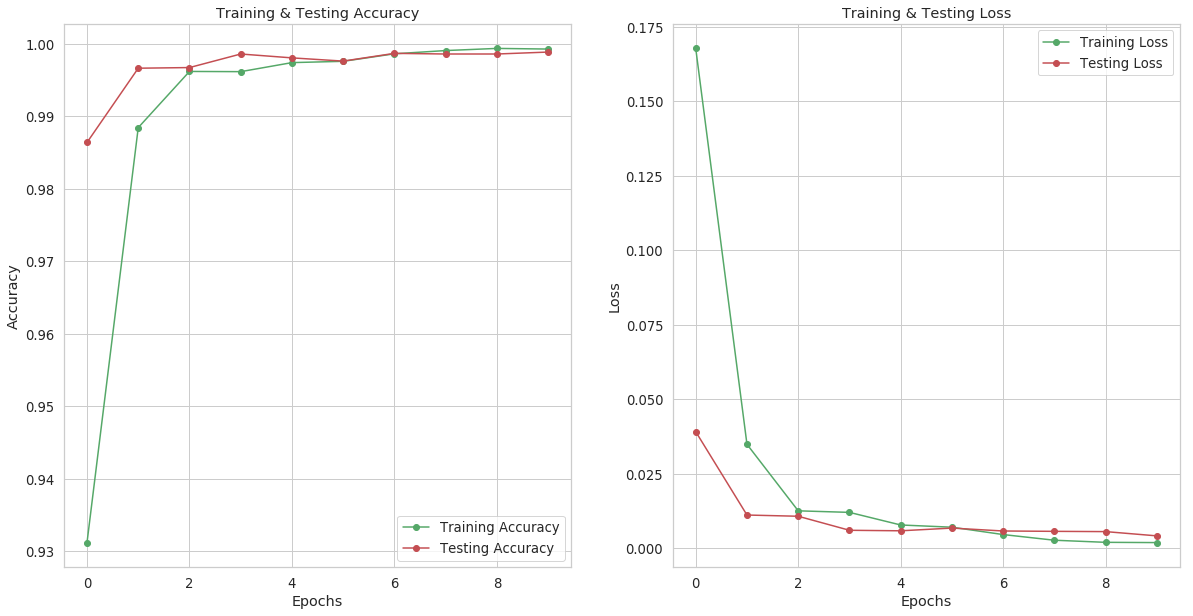

In [42]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [43]:
pred = model.predict_classes(x_test)
pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

In [44]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5858
    Not Fake       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



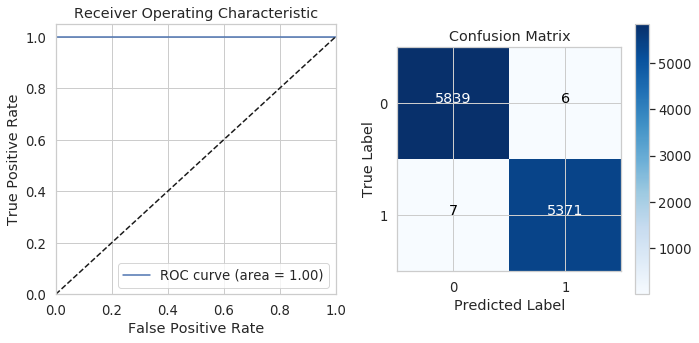

In [98]:
# 在测试集上进行预测
y_pred = model.predict(x_test)

# 计算ROC曲线和AUC值
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# 根据预测概率获取二分类预测结果
y_pred_class = np.round(y_pred)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred_class)

# 绘制ROC曲线和混淆矩阵
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 绘制ROC曲线
ax1.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right")

# 绘制混淆矩阵
im = ax2.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title('Confusion Matrix')
plt.colorbar(im, ax=ax2)
tick_marks = np.arange(2)
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_xticklabels(['0', '1'])
ax2.set_yticklabels(['0', '1'])
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax2.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()

# 保存绘制的图片
plt.savefig('../working/roc_cm_lstm.png', dpi=300, bbox_inches='tight')

plt.show()

# 计算和输出准确率
acc = accuracy_score(y_test, y_pred_class)
print("Accuracy: {:.2f}%".format(acc*100))

# 输出AUC值
print("AUC score: {:.4f}".format(auc))

# lightGBM

In [41]:
import lightgbm as lgb

In [63]:
# 将文本转换成词向量表示
X_train = np.zeros((len(x_train), 100))
for i in range(len(x_train)):
    x_arr = x_train[i, :]
    vectors = [embedding_matrix[x, :] for x in x_arr]
    if len(vectors) > 0:
        X_train[i] = np.mean(vectors, axis=0)

In [71]:
# 将文本转换成词向量表示
X_test = np.zeros((len(x_test), 100))
for i in range(len(x_test)):
    x_arr = x_test[i, :]
    vectors = [embedding_matrix[x, :] for x in x_arr]
    if len(vectors) > 0:
        X_test[i] = np.mean(vectors, axis=0)

In [80]:
# 创建 lightGBM 数据集
train_data = lgb.Dataset(X_train, label=y_train)

# 定义模型参数和训练配置
params = {'max_depth': 20, 'min_data_in_leaf': 55, 'num_leaves': 80, 'learning_rate': 0.1, 'lambda_l1': 0.1,
          'lambda_l2': 0.2, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1}

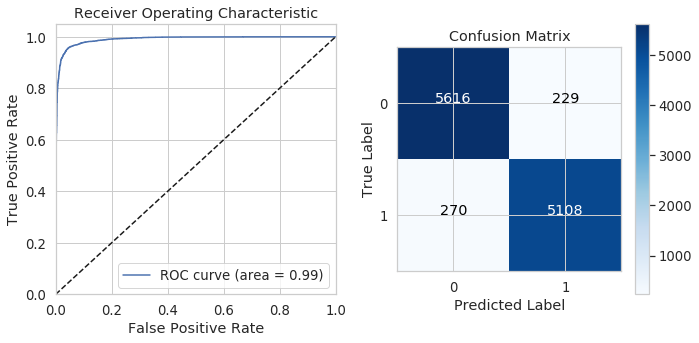

Accuracy: 95.55%
AUC score: 0.9901


In [99]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
gbm = lgb.train(params, train_data)

# 在测试集上进行预测
y_pred = gbm.predict(X_test)

# 计算ROC曲线和AUC值
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# 计算和绘制混淆矩阵
y_pred_binary = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred_binary)

# 绘制ROC曲线和混淆矩阵
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 绘制ROC曲线
ax1.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right")


# 绘制混淆矩阵
im = ax2.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title('Confusion Matrix')
plt.colorbar(im, ax=ax2)
tick_marks = np.arange(2)
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_xticklabels(['0', '1'])
ax2.set_yticklabels(['0', '1'])
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax2.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
# 保存绘制的图片
plt.savefig('../working/roc_cm_lightGBM.png', dpi=300, bbox_inches='tight')

plt.show()

# 计算和输出准确率
acc = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}%".format(acc*100))

# 输出AUC值
print("AUC score: {:.4f}".format(auc))

# SVC

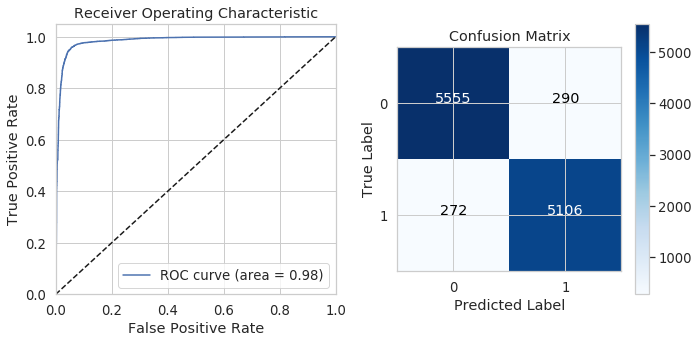

Accuracy: 94.99%
AUC score: 0.9834


In [100]:
from sklearn.svm import SVC

# 定义SVC并训练
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = svc.predict_proba(X_test)[:, 1]

# 计算ROC曲线和AUC值
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# 计算和绘制混淆矩阵
y_pred_binary = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred_binary)

# 绘制ROC曲线和混淆矩阵
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 绘制ROC曲线
ax1.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right")


# 绘制混淆矩阵
im = ax2.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title('Confusion Matrix')
plt.colorbar(im, ax=ax2)
tick_marks = np.arange(2)
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_xticklabels(['0', '1'])
ax2.set_yticklabels(['0', '1'])
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax2.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
# 保存绘制的图片
plt.savefig('../working/roc_cm_svc.png', dpi=300, bbox_inches='tight')

plt.show()

# 计算和输出准确率
acc = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}%".format(acc*100))

# 输出AUC值
print("AUC score: {:.4f}".format(auc))